In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import shutil
from sklearn.model_selection import train_test_split

In [2]:
# This will enable us solicit the use of the GPU for performing certain tf operations.
# Note this is only valid for systems with Nvidia graphics and CUDA installed as well as tensorflow-gpu
tf.debugging.set_log_device_placement(True)


tf.random.set_seed(42)

In [3]:
#Creating helping variables
root_dir = os.chdir("/home/scripter/Documents/datasets/spot the mask")
images_dir = "./images/"
train = pd.read_csv("./train_labels.csv")

train_images_id = train['image'].tolist()
test_images_id = []
images = os.listdir(images_dir)

for img in tqdm(images):
    if img not in train_images_id:
        test_images_id.append(img)

# Check for the existence of train and test image directories
def check_create():
    if os.path.exists("./train") and os.path.exists("./test"):
        print ("Paths exist")
        return False
    else:
        os.mkdir("./train")
        os.mkdir("./test")
        return True
    
# Helper function to move images to their respective directories
def move(args,source,dst):
    for img in args:
        shutil.copy(source+img,dst)
        

        
        
# Moving the actual images
if check_create() == True:
    move(train_images_id, images_dir,"./train")
    move(test_images_id, images_dir,"./test")
    

100%|██████████| 1817/1817 [00:00<00:00, 63649.31it/s]

Paths exist


### Since we are looking for probability scores, a best option would be to change the targets into categorical form thus making in easy to use a _softmax_ in the final classification layer

In [4]:
# changing target from numerical into categorical
train['target'] = train['target'].replace({0:"No_mask",1:"Mask"})


# splitting dataframe into train and validation datasets while removing the index
train_data,validation_data = train_test_split(train,test_size=0.2,random_state=42)
train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

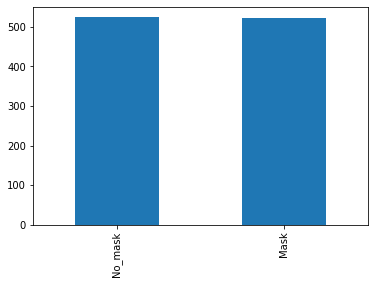

In [5]:
#Checking to be the split was succesful
train_data['target'].value_counts().plot.bar()

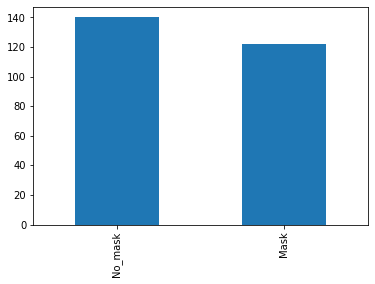

In [6]:
validation_data['target'].value_counts().plot.bar()

#### One way to improve our model is by performing data augmentation from our original dataset. Data Augmentation is a technique of creating new datasets from the old dataset using mathematical operations such is rotation, transformation, Principal Component Analysis etc. The model is then trained on both the original dataset and augmented dataset.

#### Since data augmentation increases the number of training data, it can be computationaly expensive especially if the original dataset already has a lot of data samples

In [7]:
batch_size = 32
IMAGE_SIZE = 224
IMAGE_SHAPE = (IMAGE_SIZE,IMAGE_SIZE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, 
                                                               zoom_range = 0.1,
                                                               width_shift_range=0.2,
                                                               height_shift_range=0.2,
                                                               horizontal_flip=True,
                                                               vertical_flip=False,
                                                               rescale=1./255)

validate_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

X = train_datagen.flow_from_dataframe(train_data,
                                     "./train",
                                     target_size=IMAGE_SHAPE,
                                     batch_size=batch_size,
                                     class_mode="binary",
                                     x_col="image",
                                     y_col="target",
                                     shuffle=True)

X_val = validate_datagen.flow_from_dataframe(validation_data,
                                     "./train",
                                     target_size=IMAGE_SHAPE,
                                     batch_size=batch_size,
                                     class_mode="binary",
                                     x_col="image",
                                     y_col="target",
                                     shuffle=True)

Found 1046 validated image filenames belonging to 2 classes.
Found 262 validated image filenames belonging to 2 classes.


### Model Building and Training

In this example we will be using transfer learning. Transfer learning is a technique where we use an already trained model (trained on a very large dataset) to train a new dataset within the same domain with the hopes of cutting down training time and computation resources. 

We will be using the MobileNetV2 architecture - a CNN architecture trained on the millions of images from the imagenet dataset and contains over 80 images classes.

Two are two ways to do transfer learning in tensorflow;

1. Feature Extraction - In this approach, the top layer also the classification layer of the model is replaced by a custom top layer.The weights of the pre-trained model will be frozen to prevent them from updating and only the weights of the custom top/classification layer is updated. In short,you do not retrain the entire model. The base network already contains features generic to most images. However the top layer contains features specific to the to the original dataset. That is why it is replaced with our own custom classification layer
         
2. Fine-Tuning - In this approach, you unfreeze some of the base layers and train those layers together with the newly added custom top layer to improve the performance



In [8]:
# getting the base model and freezing it
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

### Compile and Train
The reason for using a softmax instead of a sigmoid even though we are doing a binary classification is to be able to generate a probability score 

In [19]:
base_learning_rate = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=5,mode='auto',min_lr=0.0000001,factor=0.1)]


global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
pred_layer = tf.keras.layers.Dense(2,activation="softmax")

model = tf.keras.Sequential([
    base_model,
    global_avg_layer,
    pred_layer
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
history = model.fit_generator(X,validation_data=X_val,epochs=20,callbacks=callbacks,
                             steps_per_epoch=train_data.shape[0]//batch_size,verbose=1)

  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 32 steps, validate for 9 steps
Epoch 1/20
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

Epoch 13/20
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
31/32 [============================>.] - ETA: 0s - loss: 0.3916 - accuracy: 0.8360Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
32/32 [==============================] - 19s 588ms/step - loss: 0.3897 - accuracy: 0.8363 - val_loss: 0.3566 - val_accuracy: 0.8473
Epoch 14/20
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
31/32 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8635Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
32/32 [=============

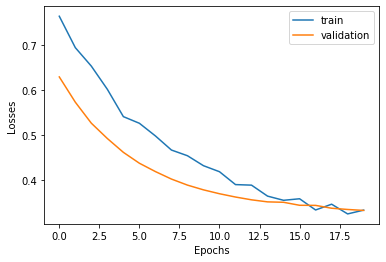

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train','validation'])
plt.show()

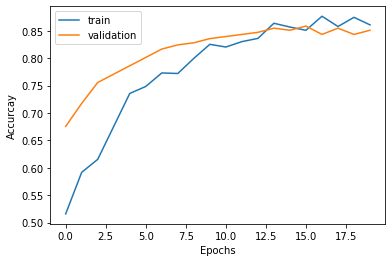

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accurcay')
plt.legend(['train','validation'])
plt.show()

## Testing phase

In [23]:
test = pd.DataFrame({"images":test_images_id})
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_dataframe(test,
                                           "./test",
                                           x_col="images",
                                           y_col=None,
                                           batch_size=batch_size,
                                           target_size=IMAGE_SHAPE,
                                           class_mode=None)
            

Found 509 validated image filenames.


In [24]:
prediction = model.predict_generator(test_data)

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_34121 in device /job:localhost/replica:0/task:0/device:GPU:0


In [25]:
prediction

array([[0.06536664, 0.9346333 ],
       [0.8318429 , 0.16815713],
       [0.539494  , 0.46050602],
       ...,
       [0.0410099 , 0.95899016],
       [0.1339626 , 0.8660374 ],
       [0.00559922, 0.9944008 ]], dtype=float32)

In [26]:
test['labels'] = np.argmax(prediction,axis=1)

In [27]:
test

,images,labels
0,pxktxhdsuefrpwxtugwuvttfgmqvyz.jpg,1
1,fwjhmiqtdoufzyyzkjzxrhzdwkcedo.jpg,0
2,nkexoipjsbhmytzjsnvxpkqhdtqidv.jpg,0
3,saqwjlvhyizasymcqwuumkayyalabr.jpg,0
4,mtjmylupexliggdaqvuamtttjbizro.jpg,0
...,...,...
504,dbuvujopjxofqfcsxghgeruyrhqamf.jpg,1
505,lkzjcblzskcxgdzssgiasoddrrtouf.jpg,0
506,yqhsjijloqxbrfjzbqnasiqfqyvgjq.jpg,1
507,lmrbtgixyoyrpexyiydyqjsexswuxr.jpg,1


In [28]:
export_dir = "/home/scripter/Documents/ml models/saved_model"
tf.saved_model.save(model,export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SaveV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SaveV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MergeV2Checkpoints in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

In [30]:
with open("/home/scripter/Documents/ml models/nose_mask.tflite","wb") as tflite_file:
    tflite_file.write(tflite_model)